# 1 Part 1:Augmented Reality with Planar **Homographies**

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
# Load the images
cap = cv2.VideoCapture('/content/book.mov')
book_img = cv2.imread('/content/cv_cover.jpg', 0)
ret, video_frame = cap.read()
book_height, book_width = book_img.shape
video_frame_gray = cv2.cvtColor(video_frame, cv2.COLOR_BGR2GRAY)


## 1.1 Getting Correspondences

In [ ]:
def getCorrespondences(img1, img2, max_matches=50, ratio_threshold=0.65, ransac_reproj_threshold=5.0, max_iterations=2000):
    #  Feature Detection and Matching:
    # The SIFT algorithm is used to detect key points (kp1, kp2) and compute their descriptors (des1, des2) for two input images (img1 and img2).
    # A Brute-Force Matcher (cv2.BFMatcher) is employed to find key point matches between the two images using the descriptors.
    sift = cv2.SIFT_create()

    # kp1: This variable holds a list of cv2.KeyPoint objects.
    # Each KeyPoint object represents a detected keypoint and contains information such as the (x, y) coordinates of the keypoint,
    # the response (a measure of how strong the keypoint is), and other properties.

    # des1: This variable holds a NumPy array that represents the descriptors associated with the keypoints.
    # Each row in des1 corresponds to the descriptor vector of a keypoint in kp1.
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    bf = cv2.BFMatcher()
    # method is used for k-nearest neighbors matching. For each descriptor in des1, it finds the two nearest descriptors in des2.
    # The parameter k=2 specifies that it should find the top 2 matches for each descriptor.
    matches = bf.knnMatch(des1, des2, k=2)
    # Filtering Matches:
    # Matches are filtered based on the ratio test. For each key point, the two best matches are considered (k=2),
    # and a match is considered valid if the distance to the best match is less than a certain ratio (ratio_threshold) times the distance to the second-best match.
    good_matches = []
    for m, n in matches:
        if m.distance < ratio_threshold * n.distance:
            good_matches.append(m)

    # Limiting the Number of Matches:
    # The number of matches is limited to max_matches by sorting the matches based on their distances and selecting the top matches.
    good_matches = sorted(good_matches, key=lambda x: x.distance)
    if len(good_matches) > max_matches:
        good_matches = good_matches[:max_matches]

    # Extract corresponding points from the initial set of matches

    # m.queryIdx is the index of the keypoint in the first image (img1).
    # m.trainIdx is the index of the keypoint in the second image (img2).
    # The list comprehension [kp1[m.queryIdx].pt for m in good_matches] extracts the (x, y) coordinates of the keypoints in the first image corresponding to the good matches.
    # np.float32(...).reshape(-1, 2) converts the list of (x, y) coordinates into a NumPy array of shape (-1, 2), where each row corresponds to a pair of (x, y) coordinates.
    src_points = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 2)
    dest_points = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 2)


    #     RANSAC for Robust Estimation:
    # RANSAC is used to robustly estimate a geometric transformation (homography matrix H) between the sets of corresponding points.
    # Randomly sampled sets of 4 correspondences are used to compute a candidate homography matrix.
    # The transformation is applied to all points, and a reprojection error is computed.
    # The set of inliers is determined based on a reprojection error threshold (ransac_reproj_threshold).
    # The process is repeated for a maximum number of iterations (max_iterations), and the best set of inliers is retained.
    best_inlier_count = 0
    best_inliers = []

    for _ in range(max_iterations):
        # Randomly sample 4 correspondences
        #  generates an array of 4 unique random indices from
        #  the set of indices corresponding to the good matches (good_matches). This random sampling is used to select a subset of
        # four correspondences to be used in estimating the geometric transformation.
        random_indices = np.random.choice(len(good_matches), 4, replace=False)
        # kp1[good_matches[i].queryIdx].pt retrieves the (x, y) coordinates of the keypoint in
        # the first image corresponding to the i-th good match. This is part of the source points (sampled_src).
        sampled_src = np.float32([kp1[good_matches[i].queryIdx].pt for i in random_indices])
        sampled_dest = np.float32([kp2[good_matches[i].trainIdx].pt for i in random_indices])

        # Compute the transformation matrix using DLT
        # Homography Computation:
        # The homography matrix (H) is computed using the function compute_homography_matrix.
        # This function is not provided in the provided code snippet, but it is assumed to be defined elsewhere in the code.
        H = compute_homography_matrix(sampled_src, sampled_dest)

        # Apply the transformation to all points
        # np.vstack((src_points.T, np.ones(len(src_points)))) stacks the transposed source points and the homogeneous coordinates vertically,
        #  creating a matrix where each column represents a point in homogeneous coordinates.
        transformed_src = np.dot(H, np.vstack((src_points.T, np.ones(len(src_points)))))

        # Normalize the transformed points
        transformed_src = transformed_src[:2, :] / transformed_src[2, :]
        transformed_src = transformed_src.T

        # Compute the reprojection error
        errors = np.linalg.norm(transformed_src - dest_points, axis=1)

        # Count inliers based on the reprojection error threshold
        inliers = np.where(errors < ransac_reproj_threshold)[0]
        inlier_count = len(inliers)

        # Update the best set of inliers
        if inlier_count > best_inlier_count:
            best_inlier_count = inlier_count
            best_inliers = inliers

    # Extract corresponding points from the best inliers
    # Output:
    # The function returns the corresponding points (src_points, dest_points) from the best set of inliers.
    # Additionally, key points (kp1, kp2) and matches corresponding to the inliers (inlier_matches) are returned.
    inlier_matches = [good_matches[i] for i in best_inliers]
    src_points = np.float32([kp1[m.queryIdx].pt for m in inlier_matches]).reshape(-1, 2)
    dest_points = np.float32([kp2[m.trainIdx].pt for m in inlier_matches]).reshape(-1, 2)

    return src_points, dest_points, kp1, kp2, inlier_matches


In [ ]:
def showMatches(book_img, video_frame, src_points, dest_points, kp1, kp2, good_matches):
    # Draw matches
    img_matches = cv2.drawMatches(book_img, kp1, video_frame, kp2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    # Plot the images and matches
    plt.figure(figsize=(12, 6))
    plt.subplot(121), plt.imshow(book_img, cmap='gray'), plt.title('Book Image')
    plt.subplot(122), plt.imshow(video_frame, cmap='gray'), plt.title('First Video Frame')
    plt.figure(figsize=(12, 6))
    plt.imshow(img_matches), plt.title('Good Matches')
    plt.show()

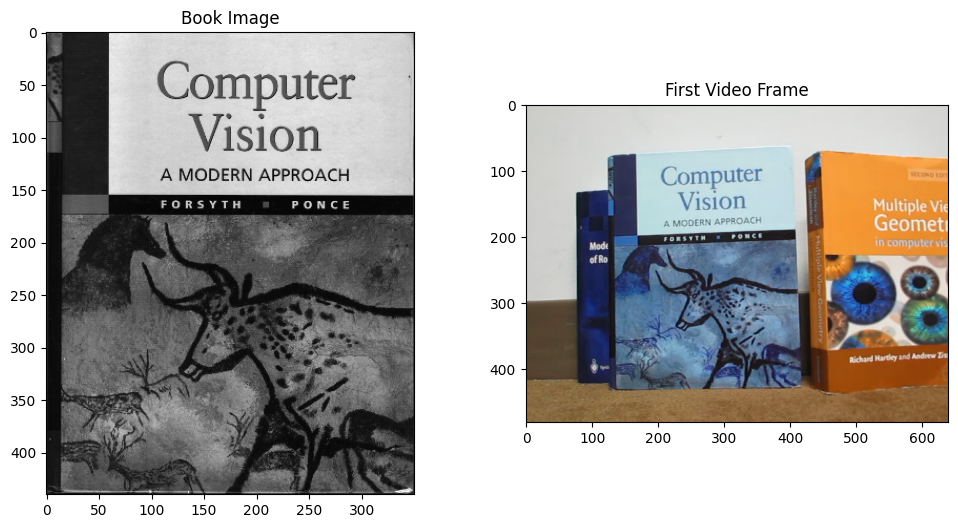

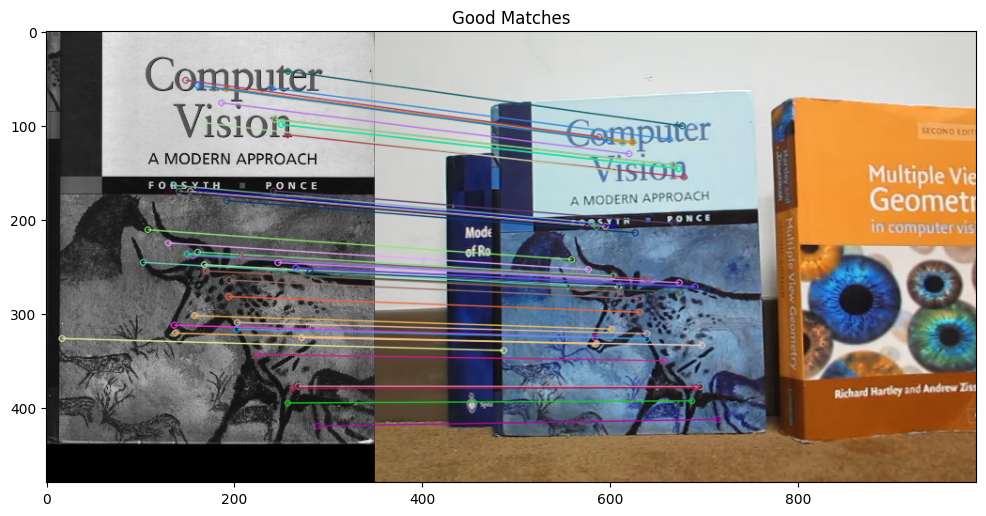

In [ ]:
src_points, dest_points, kp1, kp2, good_matches = getCorrespondences(book_img, video_frame_gray)

showMatches(book_img, video_frame, src_points, dest_points, kp1, kp2, good_matches)

## 1.2 Compute the Homography Parameters

In [ ]:
def compute_homography_matrix(src_points, dest_points):
    if len(src_points) < 4 or len(dest_points) < 4:
        raise ValueError("At least 4 corresponding points are required.")

    A = []
    for i in range(len(src_points)):
        x, y = src_points[i]
        u, v = dest_points[i]
        A.append([-x, -y, -1, 0, 0, 0, x * u, y * u, u])
        A.append([0, 0, 0, -x, -y, -1, x * v, y * v, v])

    A = np.array(A)
    _, _, V = np.linalg.svd(A)
    H = V[-1, :].reshape(3, 3)
    H /= H[2, 2]

    return H

In [ ]:
def map_points_with_homography(src_points, homography_matrix):
    homogenous_src_points = np.column_stack((src_points, np.ones((len(src_points), 1))))
    dest_points_homogeneous = np.dot(homogenous_src_points, homography_matrix.T)
    dest_points = dest_points_homogeneous[:, :2] / dest_points_homogeneous[:, 2:]
    return dest_points

In [ ]:
# Compute the homography matrix
homography_matrix = compute_homography_matrix(src_points, dest_points)
print("homography matrix ")
print(homography_matrix)


homography matrix 
[[ 7.73175746e-01  2.75722288e-03  1.19569964e+02]
 [-5.11103674e-02  7.78602152e-01  7.74981416e+01]
 [-9.11956120e-05 -7.43420640e-05  1.00000000e+00]]


## 1.3 Calculate Book Coordinates

In [ ]:
def showCorners(video_frame, mapped_book_corners):
    # Draw the original and mapped book corners on the first video frame
    video_frame_with_corners = video_frame.copy()
    for corner in mapped_book_corners:
        cv2.circle(video_frame_with_corners, tuple(map(int, corner)), 5, (0, 255, 0), -1)

    # Display the first video frame with the book corners
    plt.imshow(cv2.cvtColor(video_frame_with_corners, cv2.COLOR_BGR2RGB))
    plt.title('Video Frame with Book Corners')
    plt.show()

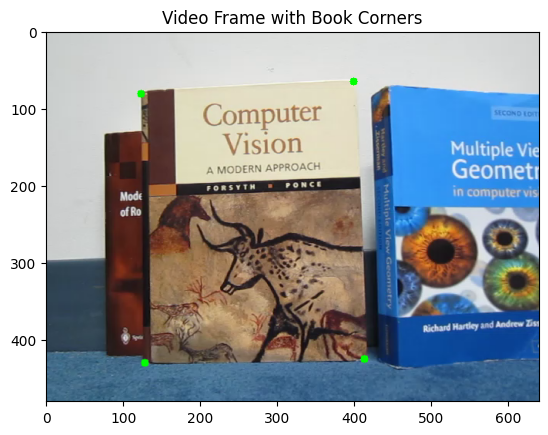

In [ ]:
# Map the four corners of the book image to the first frame in the video
book_corners = np.float32([[5, 5], [5, book_height-5], [book_width-5, book_height-5], [book_width-5, 5]]).reshape(-1, 2)
mapped_book_corners = map_points_with_homography(book_corners, homography_matrix)

showCorners(video_frame, mapped_book_corners)

## 1.4 Crop AR Video Frames

In [ ]:
mapped_book_corners

array([[123.55189115,  81.20281115],
       [128.86120899, 430.03750977],
       [413.92386211, 425.71838039],
       [399.03225356,  65.85450073]])

In [ ]:
def crop_video_frame(video_frame, height, width):
    height -= 10
    width -= 10
    aspect_ratio = width / height

    # Get the dimensions of the video frame
    frame_width, frame_height = video_frame.shape[1], video_frame.shape[0]

    # Crop the video frame
    if frame_width > frame_height * aspect_ratio:
        # If the width is larger, crop from the width
        target_width = int(frame_height * aspect_ratio)
        right_left_margin = int((frame_width - target_width) / 2)
        cropped_frame = video_frame[
            :, right_left_margin : right_left_margin + target_width, :
        ]
    else:
        # If the height is larger, crop from the height
        target_height =  int(frame_width / aspect_ratio)
        bottom_top_margin = int((frame_height - target_height) / 2)
        cropped_frame = video_frame[
            bottom_top_margin : bottom_top_margin + target_height, :, :
        ]

    return cropped_frame

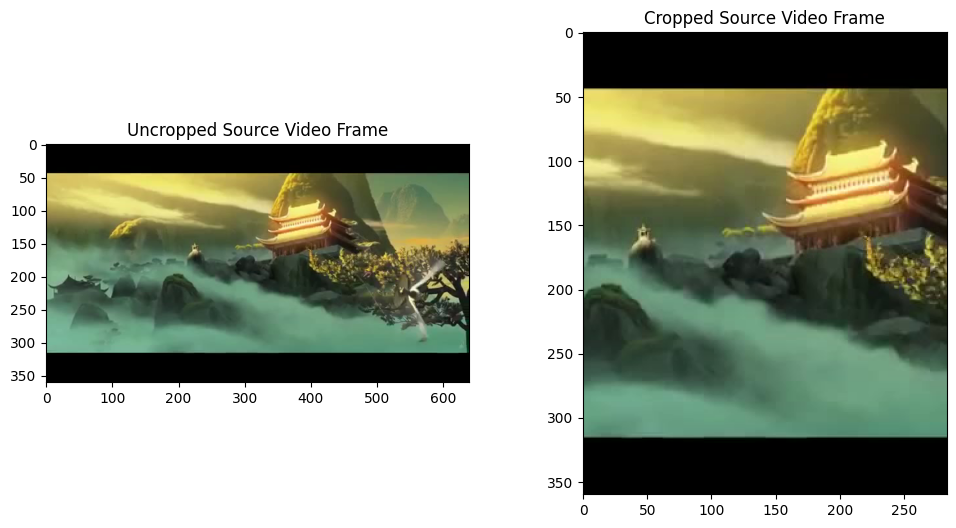

In [ ]:
# Read the video from source.mov
cap_source = cv2.VideoCapture('/content/source.mov')

# Get the first frame
ret_source, video_frame_source = cap_source.read()

# Uncropped frame
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(video_frame_source, cv2.COLOR_BGR2RGB))
plt.title('Uncropped Source Video Frame')

# Crop the first frame
cropped_frame_source = crop_video_frame(video_frame_source, book_height, book_width)

# Cropped frame
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(cropped_frame_source, cv2.COLOR_BGR2RGB))
plt.title('Cropped Source Video Frame')

# Show the plots
plt.show()

# Release the video capture
cap_source.release()


## 1.5 Overlay the First Frame of the Two Videos

In [ ]:
def overlay_frames(video_frame, cropped_frame, mapped_book_corners):
    mapped_book_corners = np.int32(mapped_book_corners)
    # Calculate the perspective transformation matrix
    matrix = cv2.getPerspectiveTransform(np.float32([[0, 0], [0, cropped_frame.shape[0]], [cropped_frame.shape[1], cropped_frame.shape[0]], [cropped_frame.shape[1], 0]]), np.float32(mapped_book_corners))

    # Warp the cropped frame using the perspective transformation matrix
    warped_cropped_frame = cv2.warpPerspective(cropped_frame, matrix, (video_frame.shape[1], video_frame.shape[0]))

    # Create a mask for the cropped region
    mask = np.zeros_like(video_frame)

    # Fill the mask with the warped cropped frame in the specified region
    cv2.fillPoly(mask, [mapped_book_corners], (255, 255, 255))

    # Replace the region with the warped cropped frame
    video_frame = cv2.bitwise_and(video_frame, cv2.bitwise_not(mask))
    video_frame = cv2.add(video_frame, warped_cropped_frame)

    return video_frame


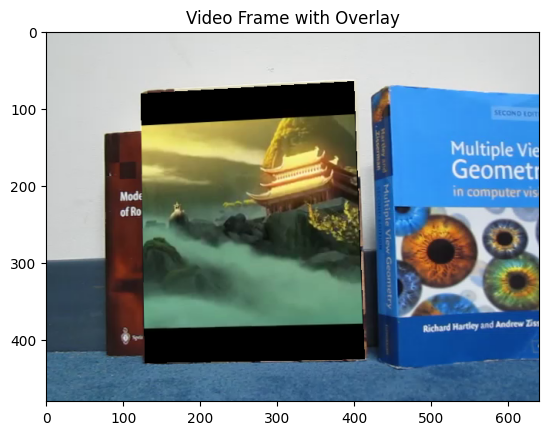

In [ ]:
# Overlay the frames
video_frame_with_overlay = overlay_frames(video_frame, cropped_frame_source, mapped_book_corners)

# Display the overlaid frame
plt.imshow(cv2.cvtColor(video_frame_with_overlay, cv2.COLOR_BGR2RGB))
plt.title('Video Frame with Overlay')
plt.show()


## 1.6 Creating AR Application

In [ ]:
def displayImg(frame, i):
  # Display the overlaid frame
  plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
  plt.title('Video Frame :' + str(i))
  plt.show()

In [ ]:
cap_book = cv2.VideoCapture('/content/book.mov')
cap_source = cv2.VideoCapture('/content/source.mov')

fps = cap_source.get(cv2.CAP_PROP_FPS)
# Get book image dimensions
ret, video_frame = cap_book.read()
height, width, _ = video_frame.shape

# Initialize video writer for output
fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v')  # Use this for .mov format
output_video = cv2.VideoWriter('/content/output_video.mov', fourcc, fps, (width, height))

frame_count_book = cap_book.get(cv2.CAP_PROP_FRAME_COUNT)
frame_count_source = cap_source.get(cv2.CAP_PROP_FRAME_COUNT)
min_frame_count = min(frame_count_book, frame_count_source)

# Loop through frames of both videos
for i in range(int(min_frame_count)):
    # Read frames
    ret_book, video_frame_book = cap.read()
    ret_source, video_frame_source = cap_source.read()

    # Convert to grayscale
    video_frame_gray = cv2.cvtColor(video_frame_book, cv2.COLOR_BGR2GRAY)

    # Get correspondences
    src_points, dest_points, kp1, kp2, good_matches = getCorrespondences(book_img, video_frame_gray)

    # Compute homography matrix
    homography_matrix = compute_homography_matrix(src_points, dest_points)

    # Map book corners with homography
    book_corners = np.float32([[5, 5], [5, book_height-5], [book_width-5, book_height-5], [book_width-5, 5]]).reshape(-1, 2)
    mapped_book_corners = map_points_with_homography(book_corners, homography_matrix)

    # Crop video frame
    cropped_frame_source = crop_video_frame(video_frame_source, book_height, width)

    # Overlay frames
    video_frame_with_overlay = overlay_frames(video_frame_book, cropped_frame_source, mapped_book_corners)

    # Write the frame to the output video
    output_video.write(video_frame_with_overlay)

# Release video capture objects and writer
cap_book.release()
cap_source.release()
output_video.release()


# 2 Part 2: Image Mosaics

## 2.1 Getting Correspondences and Compute the Homography Parameters

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from math import inf, ceil, floor

In [ ]:
!gdown 182rTRi4YLgeZHHodBLvUMe3bY3yrHuLx -O pano_image1.jpg
!gdown 1F9UkIIWqHtvHucvCcYCIADmaMHVTlDkd -O pano_image2.jpg

Downloading...
From: https://drive.google.com/uc?id=182rTRi4YLgeZHHodBLvUMe3bY3yrHuLx
To: /content/pano_image1.jpg
100% 190k/190k [00:00<00:00, 28.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1F9UkIIWqHtvHucvCcYCIADmaMHVTlDkd
To: /content/pano_image2.jpg
100% 191k/191k [00:00<00:00, 15.4MB/s]


In [ ]:
# Read images
img2 = cv2.imread('/content/pano_image1.jpg')
img1 = cv2.imread('/content/pano_image2.jpg')

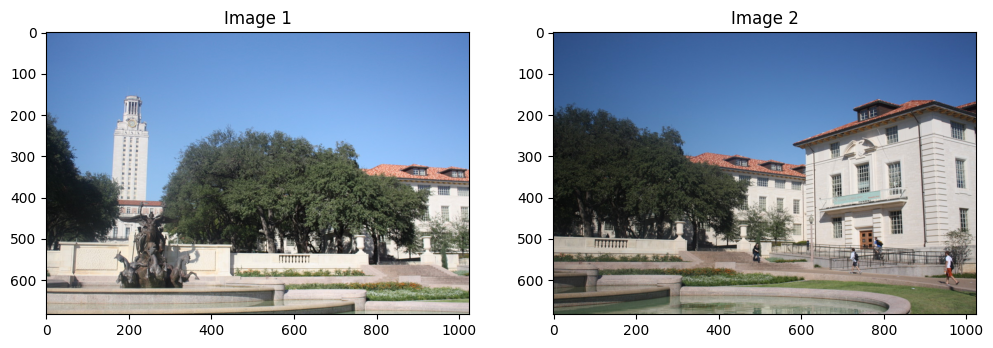

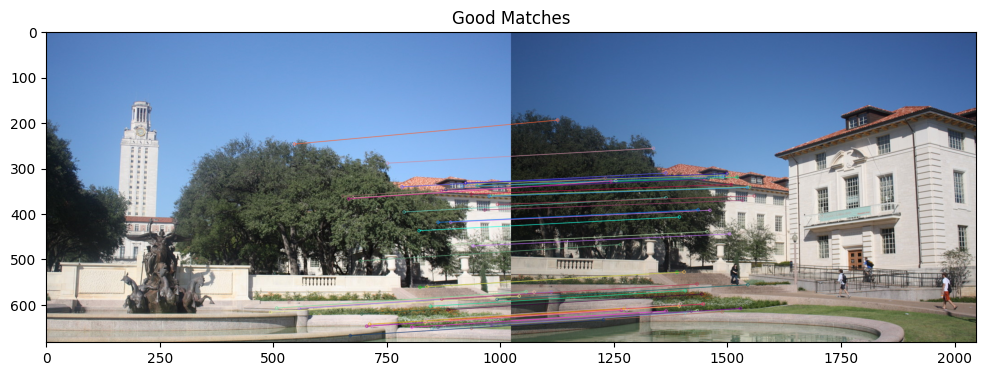

In [ ]:
# Get correspondences
src_points_mos, dest_points_mos, kp1_mos, kp2_mos, good_matches_mos = getCorrespondences(img1, img2)

# Convert BGR images to RGB for proper display
img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

# Draw matches
img_matches_mos = cv2.drawMatches(img1_rgb, kp1_mos, img2_rgb, kp2_mos, good_matches_mos, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Plot the images and matches
plt.figure(figsize=(12, 6))
plt.subplot(121), plt.imshow(img1_rgb), plt.title('Image 1')
plt.subplot(122), plt.imshow(img2_rgb), plt.title('Image 2')
plt.figure(figsize=(12, 6))
plt.imshow(img_matches_mos), plt.title('Good Matches')
plt.show()


In [ ]:
# Compute the homography matrix
H = compute_homography_matrix(src_points_mos, dest_points_mos)
print("homography matrix ")
print(H)

H_cv2 , status = cv2.findHomography(src_points_mos, dest_points_mos)
print("homography matrix built in ")
print(H_cv2)

homography matrix 
[[ 1.31300123e+00 -7.75705227e-02 -5.80984901e+02]
 [ 1.74950253e-01  1.22837502e+00 -1.72293000e+02]
 [ 2.91512216e-04  2.04681590e-05  1.00000000e+00]]
homography matrix built in 
[[ 1.31171608e+00 -7.78572300e-02 -5.80157150e+02]
 [ 1.74580093e-01  1.22707990e+00 -1.71824672e+02]
 [ 2.90840262e-04  1.95693406e-05  1.00000000e+00]]


## 2.2 Warping Between Image Planes

In [ ]:
# Function to convert image coordinates to homogeneous coordinates
def hetero_to_homo(y, x):
  return np.array([x, y, 1]).reshape((3, 1))
# Function to transform a set of points using a homography matrix
def transform(P, H):
  P_transformed = H @ P
  P_transformed = P_transformed / P_transformed[2]
  return P_transformed.reshape(-1)

In [ ]:
# Function to warp an image using a hemograpghy matrix
def warp_image_perspective(img, H):
  height, width, _ = img.shape
  # Initialize boundary coordinates for the image corners
  min_x, min_y, max_x, max_y = inf, inf, -inf, -inf
  boundaries = np.array([[0, 0], [height - 1, 0], [0, width - 1], [height - 1, width - 1]])
  # Iterate through each boundary point and transform it
  for boundary in boundaries:
    P_transformed = transform(hetero_to_homo(boundary[0], boundary[1]), H)
    min_x, min_y = min(min_x, P_transformed[0]), min(min_y, P_transformed[1])
    max_x, max_y = max(max_x, P_transformed[0]), max(max_y, P_transformed[1])
  warped_img = np.zeros((ceil(max_y - min_y), ceil(max_x - min_x), 3), dtype=np.uint8)
  # Iterate through each pixel in the original image and transform it
  for P_y in range(height):
    for P_x in range(width):
      P_transformed = transform(hetero_to_homo(P_y, P_x), H)
      warped_img[int(P_transformed[1] - min_y), int(P_transformed[0] - min_x)] = img[P_y, P_x]
  return warped_img, min_x, min_y

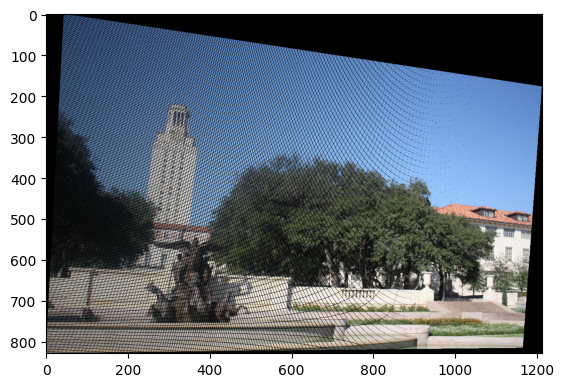

In [ ]:
warped_img, shift_x, shift_y = warp_image_perspective(img1_rgb, H)
plt.imshow(warped_img)
plt.show()

In [ ]:
#  Function to perform bilinear interpolation on a 2D image
def bilinear_interpolation(img, x, y):
  height, width, _ = img.shape
  min_x, min_y, max_x, max_y = floor(x), floor(y), ceil(x), ceil(y)
  res = 0
  if min_x >= 0 and min_x < width and min_y >= 0 and min_y < height:
    res += (1 - abs(x - min_x)) * (1 - abs(y - min_y)) * img[min_y][min_x]
  if min_x >= 0 and min_x < width and max_y >= 0 and max_y < height:
    res += (1 - abs(x - min_x)) * (1 - abs(y - max_y)) * img[max_y][min_x]
  if max_x >= 0 and max_x < width and min_y >= 0 and min_y < height:
    res += (1 - abs(x - max_x)) * (1 - abs(y - min_y)) * img[min_y][max_x]
  if max_x >= 0 and max_x < width and max_y >= 0 and max_y < height:
    res += (1 - abs(x - max_x)) * (1 - abs(y - max_y)) * img[max_y][max_x]
  return res

In [ ]:
# FUnction to remove holes from the warped image using bilinear interpolation
def remove_holes(warped_img, img, H, shift_x,shift_y):
  H_inv = np.linalg.inv(H)
  # Find indices of holes in the warped image
  holes_indices = np.where(warped_img[:, :, 0] == 0)
  # Iterate through each hole
  for i in range(len(holes_indices[0])):
    x, y= holes_indices[1][i], holes_indices[0][i]
    P = transform(hetero_to_homo(y + shift_y, x + shift_x), H_inv)
    P.reshape(-1)
    warped_img[y, x, :] = bilinear_interpolation(img, P[0], P[1])
  # Reshape the image if it is grey image
  if warped_img.shape[2] == 1:
    warped_img = warped_img.reshape(warped_img.shape[0], -1)
  return warped_img

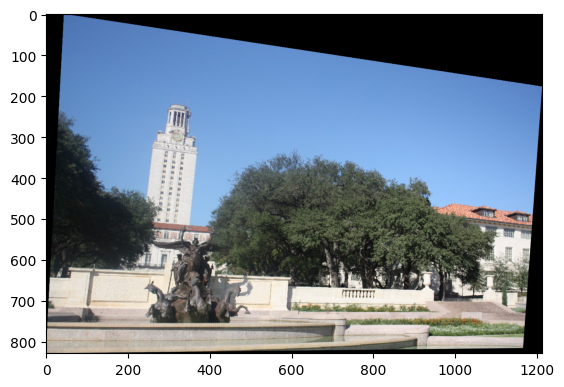

In [ ]:
warped_img = remove_holes(warped_img, img1_rgb, H, shift_x, shift_y)
plt.imshow(warped_img)
plt.show()

## 2.3 Create the output mosaic

In [ ]:
# Function to create a mosaic image by combining the warped image with the other image
def create_mosaic_img(warped_img, img, shift_x, shift_y):
  warp_shift_x,warp_shift_y = max(0, ceil(shift_x)), max(0, ceil(shift_y))
  img_shift_x, img_shift_y = max(0, ceil(-shift_x)), max(0, ceil(-shift_y))
  # Calculate the dimensions of the mosaic image
  width = max(warp_shift_x + warped_img.shape[1], img_shift_x + img.shape[1])
  height = max(warp_shift_y + warped_img.shape[0], img_shift_y + img.shape[0])
  mosaic_img = np.zeros((height, width, 3), dtype=np.uint8)
  # Place the warped image in the mosaic
  mosaic_img[warp_shift_y: warp_shift_y + warped_img.shape[0], warp_shift_x: warp_shift_x + warped_img.shape[1]] = warped_img
  # Place the second image in the mosaic
  mosaic_img[img_shift_y: img_shift_y + img.shape[0], img_shift_x: img_shift_x + img.shape[1]] = img
  return mosaic_img

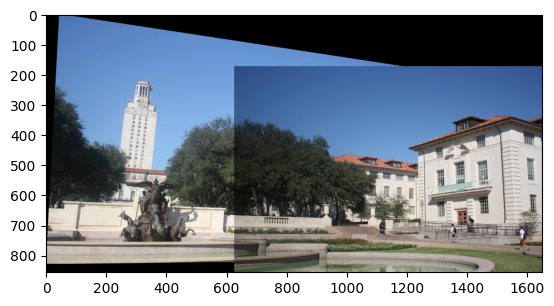

In [ ]:
mosaic_img = create_mosaic_img(warped_img, img2_rgb, shift_x, shift_y)
plt.imshow(mosaic_img)
plt.show()

In [ ]:
def stitch_images(img1, img2):
  src_points_mos, dest_points_mos, kp1_mos, kp2_mos, good_matches_mos = getCorrespondences(img1, img2)
  img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
  img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
  img_matches_mos = cv2.drawMatches(img1_rgb, kp1_mos, img2_rgb, kp2_mos, good_matches_mos, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
  H = compute_homography_matrix(src_points_mos, dest_points_mos)
  warped_img, shift_x, shift_y = warp_image_perspective(img1_rgb, H)
  warped_img = remove_holes(warped_img, img1_rgb, H, shift_x, shift_y)
  mosaic_img = create_mosaic_img(warped_img, img2_rgb, shift_x, shift_y)
  return mosaic_img

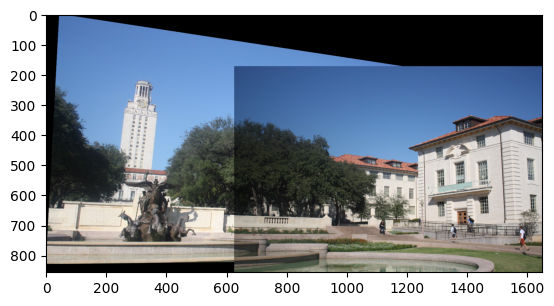

In [ ]:
plt.imshow(stitch_images(img1, img2))
plt.show()

# 3 Part 3: Bonus

In [ ]:
!gdown 1jd9UPbroCPukR2YR48MlkkHfae1bL9-Q -O shanghai-21.png
!gdown 1Mmpx05KJ__qE4iX-dKbiGT1VAb2BmPmg -O shanghai-22.png
!gdown 1ZX9-1FiuxFKXytnp70mJJV10-9A9M76_ -O shanghai-23.png

Downloading...
From: https://drive.google.com/uc?id=1jd9UPbroCPukR2YR48MlkkHfae1bL9-Q
To: /content/shanghai-21.png
100% 232k/232k [00:00<00:00, 17.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Mmpx05KJ__qE4iX-dKbiGT1VAb2BmPmg
To: /content/shanghai-22.png
100% 201k/201k [00:00<00:00, 20.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ZX9-1FiuxFKXytnp70mJJV10-9A9M76_
To: /content/shanghai-23.png
100% 246k/246k [00:00<00:00, 14.7MB/s]


In [ ]:
img1 = cv2.imread('/content/shanghai-21.png')
img2 = cv2.imread('/content/shanghai-22.png')
img3 = cv2.imread('/content/shanghai-23.png')

In [ ]:
mosiac_img1 = stitch_images(img1, img2)
mosiac_img2 = stitch_images(mosiac_img1, img3)

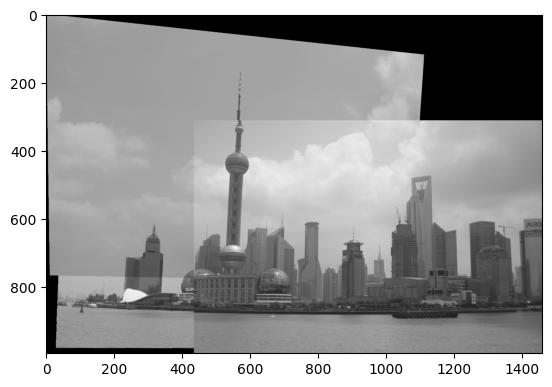

In [ ]:
plt.imshow(mosiac_img2)
plt.show()